# 门控循环单元（GRU）
:label:`sec_gru`

在 :numref:`sec_bptt` 中，我们讨论了如何在循环神经网络中计算梯度。特别是，我们还发现矩阵连续乘积可以导致梯度消失或者梯度爆炸。让我们简单思考一下这种梯度异常在实践中的意义：

* 我们可能会遇到这样的情况——早期观测值对预测所有未来观测值具有非常重要的意义。考虑一个极端情况，其中第一个观测值包含一个校验和，目标是在序列的末尾辨别校验和是否正确。在这种情况下，第一个标记的影响至关重要。我们想有某些机制能够保证在一个记忆细胞里存储重要的早期信息。如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，因为它会影响所有后续的观测值。
* 我们可能会遇到这样的情况——一些标记没有相关的观测值。例如，在解析网页时，可能有一些辅助HTML代码与评估网页上传达的情绪无关。我们希望有一些机制来 *跳过* 隐状态表示中的此类标记。
* 我们可能会遇到这样的情况——序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过渡存在，或者证券的熊市和牛市之间可能会有过渡存在。在这种情况下，最好有一种方法来 *重置* 我们的内部状态表示。

在学术界已经提出了许多方法来解决这个问题。其中最早的方法是"长－短期记忆" （long-short-term memory, LSMT）:cite:`Hochreiter.Schmidhuber.1997` ，我们将在 :numref:`sec_lstm` 中讨论。门控循环单元（gated recurrent unit, GRU） :cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` 是一个稍微简化的变体，通常能够提供同等的效果，并且计算 :cite:`Chung.Gulcehre.Cho.ea.2014` 的速度明显更快。由于它更简单，就让我们从门控循环单元开始。

## 门控隐藏状态

普通的循环神经网络和门控循环单元之间的关键区别在于后者支持隐藏状态的门控（或者说选通）。这意味着有专门的机制来确定应该何时 *更新* 隐藏状态，以及应该何时 *重置* 隐藏状态。这些机制是可学习的，并且能够解决了上面列出的问题。例如，如果第一个标记非常重要，我们将学会在第一次观测之后不更新隐藏状态。同样，我们也可以学会跳过不相关的临时观测。最后，我们还将学会在需要的时候重置隐藏状态。下面我们将详细讨论。

### 重置门和更新门

我们首先要介绍的是 *重置门*（reset gate）和 *更新门*（update gate）。我们把它们设计成 $(0, 1)$ 区间中的向量，这样我们就可以进行凸组合。例如，重置门允许我们控制可能还想记住的过去状态的数量。同样，更新门将允许我们控制新状态中有多少个是旧状态的副本。

我们从构造这些门控开始。 :numref:`fig_gru_1` 描述了门控循环单元中的重置门和更新门的输入，输入是由当前时间步的输入和前一时间步的隐藏状态给出。两个门的输出是由使用 sigmoid 激活函数的两个全连接层给出。

![在门控循环单元模型中计算重置门和更新门。](../img/gru-1.svg)
:label:`fig_gru_1`

数学描述，对于给定的时间步 $t$，假设输入是一个小批量 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ （样本个数：$n$，输入个数：$d$），上一个时间步的隐藏状态是 $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$（隐藏单元个数：$h$）。然后，重置门 $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ 和更新门 $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ 的计算如下：

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

其中 $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ 是偏置参数。请注意，在求和过程中会触发广播机制（请参阅 :numref:`subsec_broadcasting` ）。我们使用 sigmoid 函数（如 :numref:`sec_mlp` 中介绍的）将输入值转换到区间 $(0, 1)$。

### 候选隐藏状态

接下来，让我们将重置门 $\mathbf{R}_t$ 与 :eqref:`rnn_h_with_state` 中的常规隐状态更新机制集成，得到在时间步 $t$ 的候选隐藏状态 $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
:eqlabel:`gru_tilde_H`

其中 $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ 是偏置项，符号 $\odot$ 是哈达码乘积（按元素乘积）运算符。在这里，我们使用 tanh 非线性激活函数来确保候选隐藏状态中的值保持在区间 $(-1, 1)$ 中。

计算的结果是 *候选者*（candidate），因为我们仍然需要结合更新门的操作。与 :eqref:`rnn_h_with_state` 相比 :eqref:`gru_tilde_H` 中的 $\mathbf{R}_t$ 和 $\mathbf{H}_{t-1}$ 的元素相乘可以减少以往状态的影响。每当重置门 $\mathbf{R}_t$ 中的项接近 $1$ 时，我们恢复一个如 :eqref:`rnn_h_with_state` 中的普通的循环神经网络。对于重置门 $\mathbf{R}_t$ 中所有接近 $0$ 的项，候选隐藏状态是以 $\mathbf{X}_t$ 作为输入的多层感知机的结果。因此，任何预先存在的隐藏状态都会被 *重置* 为默认值。

:numref:`fig_gru_2`说明了应用重置门之后的计算流程。

![在门控循环单元模型中计算候选隐藏状态。](../img/gru-2.svg)
:label:`fig_gru_2`

### 隐藏状态

最后，我们需要结合更新门 $\mathbf{Z}_t$ 的效果。这确定新的隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ 在多大程度上就是旧的状态 $\mathbf{H}_{t-1}$ ，以及对新的候选状态 $\tilde{\mathbf{H}}_t$ 的使用量。更新门 $\mathbf{Z}_t$ 仅需要在 $\mathbf{H}_{t-1}$ 和 $\tilde{\mathbf{H}}_t$ 之间进行按元素的凸组合就可以实现这个目标。这就得出了门控循环单元的最终更新公式：

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

每当更新门 $\mathbf{Z}_t$ 接近 $1$ 时，我们就只保留旧状态。此时，来自 $\mathbf{X}_t$ 的信息基本上被忽略，从而有效地跳过了依赖链条中的时间步 $t$。相反，当 $\mathbf{Z}_t$ 接近 $0$ 时，新的隐藏状态 $\mathbf{H}_t$ 就会接近候选的隐藏状态 $\tilde{\mathbf{H}}_t$。这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。例如，如果整个子序列的所有时间步的更新门都接近于 $1$，则无论序列的长度如何，在序列起始时间步的旧隐藏状态都将很容易保留并传递到序列结束。

:numref:`fig_gru_3` 说明了更新门起作用后的计算流。

![计算门控循环单元模型中的隐藏状态。](../img/gru-3.svg)
:label:`fig_gru_3`

总之，门控循环单元具有以下两个显著特征：

* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。

## 从零开始实现

为了更好地理解门控循环单元模型，让我们从零开始实现它。首先，读取 :numref:`sec_rnn_scratch` 中使用的时间机器数据集。下面给出了读取数据集的代码。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### [**初始化模型参数**]

下一步是初始化模型参数。我们从标准差为 $0.01$ 的高斯分布中提取权重，并将偏置项设为 $0$，超参数 `num_hiddens` 定义隐藏单元的数量，实例化与更新门、重置门、候选隐藏状态和输出层相关的所有权重和偏置。


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐藏状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

现在我们将[**定义隐藏状态的初始化函数**] `init_gru_state`。与 :numref:`sec_rnn_scratch` 中定义的 `init_rnn_state` 函数一样，此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。


In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

现在我们准备[**定义门控循环单元模型**]，模型的结构与基本的循环神经网络单元是相同的，只是权重更新公式更为复杂。


In [4]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### [**训练**]与预测

训练和预测的工作方式与 :numref:`sec_rnn_scratch` 完全相同。训练结束后，我们分别打印输出训练集的困惑度和前缀“time traveler”和“traveler”的预测序列上的困惑度。


perplexity 1.1, 25305.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller scone scallex slansthanditmy said the time travel


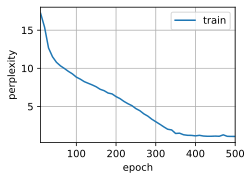

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## [**简洁实现**]

高级 API 包含了前文介绍的所有配置细节，所以我们可以直接实例化门控循环单元模型。这段代码的运行速度要快得多，因为它使用的是编译好的运算符而不是 Python 来处理之前阐述的许多细节。


perplexity 1.0, 306073.8 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


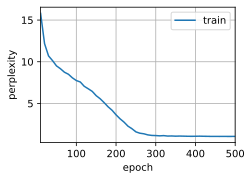

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 小结

* 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
* 重置门有助于捕获序列中的短期依赖关系。
* 更新门有助于捕获序列中的长期依赖关系。
* 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

## 练习

1. 假设我们只想使用时间步 $t'$ 的输入来预测时间步 $t > t'$ 的输出。对于每个时间步，重置门和更新门的最佳值是什么？
1. 调整和分析超参数对运行时间、困惑度和输出顺序的影响。
1. 比较 `rnn.RNN` 和 `rnn.GRU` 的不同实现对运行时间、困惑度和输出字符串的影响。
1. 如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？


# 长短期记忆网络（LSTM）
:label:`sec_lstm`

长期以来，隐变量模型存在着长期信息保存和短期输入跳跃的问题。解决这一问题的最早方法之一是长短期存储器（long short-term memory, LSTM） :cite:`Hochreiter.Schmidhuber.1997`。它有许多与门控循环单元一样的属性。有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些，却比门控循环单元 (:numref:`sec_gru`)早诞生了近20年。

## 门控记忆单元

可以说，长短期记忆网络的设计灵感来自于计算机的逻辑门。长短期记忆网络引入了 *存储单元*（memory cell），或简称为 *单元*（cell）。有些文献认为存储单元是隐藏状态的一种特殊类型，它们与隐藏状态具有相同的形状，其设计目的是用于记录附加的信息。为了控制存储单元，我们需要许多门。其中一个门用来从单元中读出条目。我们将其称为 *输出门*（output gate）。
另外一个门用来决定何时将数据读入单元。我们将其称为 *输入门*（input gate）。最后，我们需要一种机制来重置单元的内容，由*遗忘门*（forget gate）来管理。这种设计的动机与门控循环单元相同，即能够通过专用机制决定什么时候记忆或忽略隐藏状态中的输入。让我们看看这在实践中是如何运作的。

### 输入门、忘记门和输出门

就如在门控循环单元中一样，当前时间步的输入和前一个时间步的隐藏状态作为数据送入长短期记忆网络门中，如 :numref:`lstm_0` 所示。它们由三个具有 sigmoid 激活函数的全连接层处理，以计算输入门、遗忘门和输出门的值。因此，这三个门的值都在 $(0, 1)$ 的范围内。

![在长短期记忆模型中计算输入门、遗忘门和输出门。](../img/lstm-0.svg)
:label:`lstm_0`

数学描述，假设有 $h$ 个隐藏单元，批量大小为 $n$，输入数为 $d$。因此，输入为 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$，前一时间步的隐藏状态为 $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。相应地，时间步 $t$ 的门被定义如下：输入门是 $\mathbf{I}_t \in \mathbb{R}^{n \times h}$，遗忘门是 $\mathbf{F}_t \in \mathbb{R}^{n \times h}$，输出门是 $\mathbf{O}_t \in \mathbb{R}^{n \times h}$。它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中 $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ 是偏置参数。

### 候选记忆单元

接下来，设计记忆单元。由于还没有指定各种门的操作，所以先介绍 *候选记忆单元*（candidate memory cell）$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。它的计算与上面描述的三个门的计算类似，但是使用 $\tanh$ 函数作为激活函数，函数的值范围为 $(-1, 1)$。下面导出在时间步 $t$ 处的方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中 $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ 是权重参数，$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ 是偏置参数。

候选记忆单元的图示如 :numref:`lstm_1` 。

![在长短期记忆模型中计算候选记忆单元。](../img/lstm-1.svg)
:label:`lstm_1`

### 记忆单元

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。类似地，在长短期记忆网络中，也有两个门用于这样的目的：输入门 $\mathbf{I}_t$ 控制采用多少来自 $\tilde{\mathbf{C}}_t$ 的新数据，而遗忘门 $\mathbf{F}_t$ 控制保留了多少旧记忆单元 $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ 的内容。使用与前面相同的按元素做乘法的技巧，得出以下更新公式：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果遗忘门始终为 $1$ 且输入门始终为 $0$，则过去的记忆单元 $\mathbf{C}_{t-1}$ 将随时间被保存并传递到当前时间步。引入这种设计是为了缓解梯度消失问题，并更好地捕获序列中的长距离依赖关系。

这样就得到了流程图，如:numref:`lstm_2`。

![在长短期记忆网络模型中计算存储单元。](../img/lstm-2.svg)

:label:`lstm_2`

### 隐藏状态

最后，我们需要定义如何计算隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times h}$。这就是输出门发挥作用的地方。在长短期记忆网络中，它仅仅是记忆单元的 $\tanh$ 的门控版本。这就确保了 $\mathbf{H}_t$ 的值始终在区间 $(-1, 1)$ 内。

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近 $1$，我们就能够有效地将所有记忆信息传递给预测部分，而对于输出门接近 $0$，我们只保留存储单元内的所有信息，并且没有进一步的过程需要执行。

:numref:`lstm_3`提供了数据流的图形化演示。

![在长短期记忆模型中计算隐藏状态。](../img/lstm-3.svg)
:label:`lstm_3`

## 从零开始实现

现在，让我们从零开始实现长短期记忆网络。与 :numref:`sec_rnn_scratch` 中的实验相同，我们首先加载时光机器数据集。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### [**初始化模型参数**]

接下来，我们需要定义和初始化模型参数。如前所述，超参数 `num_hiddens` 定义隐藏单元的数量。我们按照标准差 $0.01$ 的高斯分布初始化权重，并将偏置项设为 $0$。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆单元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

在[**初始化函数**]中，长短期记忆网络的隐藏状态需要返回一个 *额外* 的记忆单元，单元的值为0，形状为（批量大小，隐藏单元数）。因此，我们得到以下的状态初始化。


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

[**实际模型**]的定义与我们前面讨论的一样：提供三个门和一个额外的记忆单元。请注意，只有隐藏状态才会传递到输出层，而记忆单元 $\mathbf{C}_t$ 不直接参与输出计算。


In [4]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### [**训练**]和预测

让我们通过实例化 :numref:`sec_rnn_scratch` 中引入的 `RNNModelScratch` 类来训练一个长短期记忆网络，就如我们在 :numref:`sec_gru` 中所做的一样。


perplexity 1.1, 20014.6 tokens/sec on cuda:0
time traveller a tonccrevely one mersald a dontht realfat ond to
travelleryou can show black is white by argument said filby


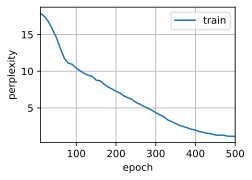

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## [**简洁实现**]

使用高级 API，我们可以直接实例化 `LSTM` 模型。模型封装了前文明确介绍的所有配置细节。这段代码的运行速度要快得多，因为它使用的是编译好的运算符而不是 Python 来处理之前阐述的许多细节。


perplexity 1.2, 285511.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller wht sat one worsesthan shith whl grreat to cevent


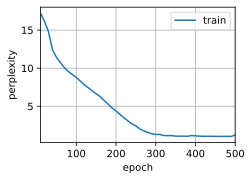

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。然而，由于序列的长距离依赖性，训练长短期记忆网络和其他序列模型（例如门控循环单元）的成本是相当高的。在后面的内容中，我们将遇到可在某些情况下使用的替代模型，如 Transformer。

## 小结

* 长短期记忆网络有三种类型的门：输入门、遗忘门和控制信息流的输出门。
* 长短期记忆网络的隐藏层输出包括“隐藏状态”和“记忆单元”。只有隐藏状态会传递到输出层，而记忆单元完全属于内部信息。
* 长短期记忆网络可以缓解梯度消失和梯度爆炸。

## 练习

1. 调整和分析超参数对运行时间、困惑度和输出顺序的影响。
1. 你需要如何更改模型以生成适当的单词，而不是字符序列？
1. 在给定隐藏层维度的情况下，比较门控循环单元、长短期记忆网络和常规循环神经网络的计算成本。要特别注意训练和推理成本。
1. 既然候选记忆单元通过使用 $\tanh$ 函数来确保值范围在 $(-1,1)$ 之间，那么为什么隐藏状态需要再次使用 $\tanh$ 函数来确保输出值范围在 $(-1,1)$ 之间呢？
1. 实现一个能够基于时间序列进行预测而不是基于字符序列进行预测的长短期记忆网络模型。


# 双向循环神经网络
:label:`sec_bi_rnn`

在序列学习中，我们以往假设的目标是：到目前为止，在给定观测的情况下对下一个输出进行建模。例如，在时间序列的上下文中或在语言模型的上下文中。虽然这是一个典型的情况，但这并不是我们可能遇到的唯一情况。为了说明这个问题，考虑以下三个在文本序列中填空的任务：

* 我 `___`。
* 我 `___` 饿了。
* 我 `___` 饿了，我可以吃半头猪。

根据可获得的信息量，我们可以用不同的词填空，如“很高兴”（"happy"）、“不”（"not"）和“非常”（"very"）。很明显，短语的结尾（如果有的话）传达了重要信息，而这些信息关乎到选择哪个词来填空，所以不能利用这一点的序列模型将在相关任务上表现不佳。例如，如果要做好命名实体识别（例如，识别“Green”指的是“格林先生”还是绿色），不同长度的上下文范围重要性是相同的。为了获得一些解决问题的灵感，让我们先迂回到概率图模型。

## 隐马尔可夫模型中的动态规划

这一小节是用来说明动态规划问题的，具体的技术细节对于理解深度学习模型并不重要，但它们有助于人们思考为什么要使用深度学习，以及为什么要选择特定的结构。

如果我们想用概率图模型来解决这个问题，可以设计一个隐变量模型，如下图所示。在任意时间步 $t$，假设存在某个隐变量 $h_t$，通过概率 $P(x_t \mid h_t)$ 控制我们观测到的发射 $x_t$。此外，任何转移 $h_t \to h_{t+1}$ 都是由一些状态转移概率 $P(h_{t+1} \mid h_{t})$ 给出。这个概率图模型就是一个 *隐马尔可夫模型*（hidden Markov model，HMM），如 :numref:`fig_hmm` 所示。

![隐马尔可夫模型。](../img/hmm.svg)
:label:`fig_hmm`

因此，对于有 $T$ 个观测值的序列，我们在观测状态和隐藏状态上具有以下联合概率分布：

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`

现在假设我们观测到所有的 $x_i$，除了 $x_j$，并且我们的目标是计算 $P(x_j \mid x_{-j})$，其中 $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。由于 $P(x_j \mid x_{-j})$ 中没有隐变量，因此我们考虑对 $h_1, \ldots, h_T$ 的选择构成的所有可能的组合进行求和。如果任何 $h_i$ 可以接受 $k$ 个不同的值（有限的状态数），这意味着我们需要对 $k^T$ 个项求和，这个任务是不可能完成的！幸运的是，有一个优雅的解决方案——*动态规划*（dynamic programming）。

要了解它的工作方式，请考虑对隐变量 $h_1, \ldots, h_T$ 的依次求和。根据 :eqref:`eq_hmm_jointP`，将得出：

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

通常，我们将“前向递归”（forward recursion）写为：

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

递归被初始化为 $\pi_1(h_1) = P(h_1)$。符号简化，也可以写成 $\pi_{t+1} = f(\pi_t, x_t)$，其中 $f$ 是一些可学习的函数。这看起来就像我们在循环神经网络中讨论的隐变量模型中的更新方程。

与前向递归一样，我们也可以使用后向递归对同一组隐变量求和。这将得到：

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

因此，我们可以将“后向递归”（backward recursion）写为：

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

初始化 $\rho_T(h_T) = 1$。前向和后向递归都允许我们对 $T$ 个隐变量在 $\mathcal{O}(kT)$（线性而不是指数）时间内对 $(h_1, \ldots, h_T)$ 的所有值求和。这是使用图模型进行概率推理的巨大好处之一。它也是通用消息传递算法 :cite:`Aji.McEliece.2000` 的一个非常特殊的例子。结合前向和后向递归，我们能够计算

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

注意到因为符号简化的需要，后向递归也可以写为 $\rho_{t-1} = g(\rho_t, x_t)$，其中 $g$ 是一个可以学习的函数。同样，这看起来非常像一个更新方程，只是不像我们在循环神经网络中看到的那样前向运算，而是后向计算。事实上，知道未来数据何时可用对隐马尔可夫模型是有益的。信号处理科学家将是否知道未来观测这两种情况区分为内插和外推。有关更多详细信息，请参阅一本书 :cite:`Doucet.De-Freitas.Gordon.2001`。

## 双向模型

如果我们希望在循环神经网络中拥有一种机制，使之能够提供与隐马尔可夫模型类似的前瞻能力，我们就需要修改循环神经网络的设计。幸运的是，这在概念上很容易，只需要增加一个从最后一个标记开始从后向前运行的循环神经网络，而不是只有一个在前向模式下从第一个标记开始运行的循环神经网络。
*双向循环神经网络*（bidirectional RNNs）添加了反向传递信息的隐藏层，以便更灵活地处理此类信息。 :numref:`fig_birnn` 描述了具有单个隐藏层的双向循环神经网络的结构。

![双向循环神经网络的结构。](../img/birnn.svg)
:label:`fig_birnn`

事实上，这与隐马尔可夫模型中的动态规划的前向和后向递归没有太大区别。其主要区别是，在隐马尔可夫模型中的方程具有特定的统计意义。双向循环神经网络没有这样容易理解的解释，我们只能把它们当作通用的、可学习的函数。这种转变集中体现了现代深度网络的设计原则：首先使用的是经典统计模型的函数依赖类型，然后将其参数化为通用形式。

### 定义

双向循环神经网络是由 :cite:`Schuster.Paliwal.1997` 提出的，关于各种结构的详细讨论请参阅 :cite:`Graves.Schmidhuber.2005`。让我们看看这样一个网络的细节。

对于任意时间步 $t$，给定一个小批量的输入数据 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$（样本数：$n$，每个示例中的输入数：$d$），并且令隐藏层激活函数为 $\phi$。在双向结构中，我们设该时间步的前向和反向隐藏状态分别为 $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ 和 $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，其中 $h$ 是隐藏单元的数目。前向和反向隐藏状态的更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中，权重 $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$  和偏置 $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ 都是模型参数。

接下来，将前向隐藏状态 $\overrightarrow{\mathbf{H}}_t$ 和反向隐藏状态 $\overleftarrow{\mathbf{H}}_t$ 连续起来，获得需要送入输出层的隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。在具有多个隐藏层的深度双向循环神经网络中，该信息作为输入传递到下一个双向层。最后，输出层计算得到的输出为 $\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$ 是输出单元的数目）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

这里，权重矩阵 $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ 和偏置 $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 是输出层的模型参数。事实上，这两个方向可以拥有不同数量的隐藏单元。

### 模型的计算成本及其应用

双向循环神经网络的一个关键特性是，使用来自序列两端的信息来估计输出。也就是说，我们使用来自过去和未来的观测信息来预测当前的观测。但是在对下一个标记进行预测的案例中，这样的行为并不是我们想要的。因为在预测下一个标记时，我们终究是无法知道下一个标记的下一个是什么。因此，如果我们幼稚地基于双向循环神经网络进行预测时，将不会得到很好的准确性：因为在训练期间，我们能够利用过去和未来的数据来估计现在，而在测试期间，我们只有过去的数据，因此准确性将会很差。下面，我们将在实验中说明这一点。

另一个严重问题是，双向循环神经网络的计算速度非常慢。其主要原因是网络的前向传播需要在双向层中进行前向和后向递归，并且网络的反向传播还依赖于前向传播的结果。因此，梯度求解将有一个非常长的依赖链。

双向层的使用在实践中非常少，并且仅仅应用于部分场合。例如，填充缺失的单词、标记注释（例如，用于命名实体识别）以及作为序列处理工作流中的一个步骤对序列进行编码（例如，用于机器翻译）。在 :numref:`sec_bert` 和 :numref:`sec_sentiment_rnn` 中，我们将介绍如何使用双向循环神经网络编码文本序列。

## (**双向循环神经网络的错误应用**)

众所周知，双向循环神经网络使用了过去的和未来的数据这是事实，而如果我们忽略基于事实的那些建议，并将其应用于语言模型，那么我们也能得到令人可以接受的困惑度估计。尽管如此，如下面的实验所示，该模型预测未来标记的能力也存在严重的缺陷。尽管困惑度是合理的，但是经过多次迭代模型也只能生成乱码。我们用下面的代码引以为戒，以防在错误的环境中使用它们。


perplexity 1.1, 99668.9 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


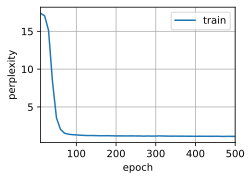

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置'bidirective=True'来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

基于上述原因，结果显然令人失望。关于如何更有效地使用双向循环神经网络的讨论，请参阅 :numref:`sec_sentiment_rnn` 中的情感分类应用。

## 小结

* 在双向循环神经网络中，每个时间步的隐藏状态由当前时间步的前后数据同时决定。
* 双向循环神经网络与概率图模型中的“前向-后向”算法有着惊人的相似性。
* 双向循环神经网络主要用于序列编码和给定双向上下文的观测估计。
* 由于梯度链更长，因此双向循环神经网络的训练成本非常高。

## 练习

1. 如果不同方向使用不同数量的隐藏单位，$\mathbf{H_t}$ 的形状会发生怎样的变化？
1. 设计一个具有多个隐藏层的双向循环神经网络。
1. 在自然语言中一词多义很常见。例如，“bank”一词在不同的上下文“i went to the bank to deposit cash”和“i went to the bank to sit down”中有不同的含义。如何设计一个神经网络模型，使其在给定上下文序列和单词的情况下，返回该单词在此上下文中的向量表示？哪种类型的神经网络结构更适合处理一词多义？


# 机器翻译与数据集
:label:`sec_machine_translation`

首先，语言模型是使用循环神经网络来设计的，而语言模型正是自然语言处理的关键。其次，*机器翻译* 是最成功的基准测试，而机器翻译正是将输入序列转换成输出序列的 *序列转换模型*（sequence transduction）的核心问题。因为序列转换模型在各种现代的人工智能应用中发挥着至关重要的作用，因此其将成为本章剩余部分和 :numref:`chap_attention` 的重点。为此，本节将介绍机器翻译问题及其稍后需要使用的数据集。

*机器翻译*（machine translation）指的是将序列从一种语言自动翻译成另一种语言。事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，特别是在第二次世界大战中使用计算机破解语言编码。几十年来，在使用神经网络进行端到端学习的兴起之前，统计学方法在这一领域一直占据主导地位 :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990` 。因为 *统计机器翻译*（statistical machine translation）涉及了翻译模型和语言模型等组成部分的统计分析，因此基于神经网络的方法通常被称为 *神经机器翻译*（neural machine translation），用于将两种翻译模型区分开来。

本书的关注点是神经机器翻译方法，强调的是端到端的学习。与 :numref:`sec_language_model` 中的语料库是单一语言的语言模型问题存在不同，机器翻译的数据集是由源语言和目标语言的文本序列对组成的。因此，我们需要一种完全不同的方法来预处理机器翻译数据集，而不是复用语言模型的预处理程序。下面，我们将展示如何将预处理后的数据加载到小批量中用于训练。


In [1]:
import os
import torch
from d2l import torch as d2l

## [**下载和预处理数据集**]

首先，下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)组成的“英－法”数据集，数据集中的每一行都是制表符分隔文本序列对，序列对由英文文本序列和翻译后的法语文本序列组成。请注意，每个文本序列可以是一个句子，也可以是包含多个句子的一个段落。在这个将英语翻译成法语的机器翻译问题中，英语是 *源语言*（source language），法语是 *目标语言*（target language）。


In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集。"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



下载数据集后，我们对原始的文本数据进行处理需要经过[**几个预处理步骤**]。例如，我们用空格代替 *不间断空格*（non-breaking space），使用小写字母替换大写字母，并在单词和标点符号之间插入空格。


In [3]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集。"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## [**词元化**]

与 :numref:`sec_language_model` 中的字符级词元化不同，在机器翻译中，我们更喜欢单词级词元化（最先进的模型可能使用更高级的词元化技术）。下面的 `tokenize_nmt` 函数对前 `num_examples` 个文本序列对进行标记，其中每个标记要么是一个单词，要么是一个标点符号。此函数返回两个标记列表：`source` 和 `target`。具体地说，`source[i]` 是源语言（这里是英语）第 $i$ 个文本序列的标记列表，`target[i]` 是目标语言（这里是法语）第 $i$ 个文本序列的标记列表。


In [4]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集。"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

让我们[**绘制每个文本序列所包含的标记数量的直方图**]。在这个简单的“英－法”数据集中，大多数文本序列的标记数量少于 $20$ 个。


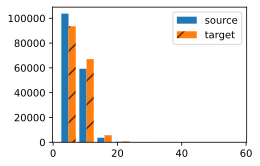

In [5]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

## [**词汇表**]

由于机器翻译数据集由语言对组成，因此我们可以分别为源语言和目标语言构建两个词汇表。使用单词级词元化时，词汇量将明显大于使用字符级词元化时的词汇量。为了缓解这一问题，这里我们将出现次数少于2次的低频率标记视为相同的未知（“&lt;unk&gt;”）标记。除此之外，我们还指定了额外的特定标记，例如在小批量时用于将序列填充到相同长度的填充标记（“&lt;pad&gt;”），以及序列的开始标记（“&lt;bos&gt;”）和结束标记（“&lt;eos&gt;”）。这些特殊标记在自然语言处理任务中比较常用。


In [6]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## 加载数据集
:label:`subsec_mt_data_loading`

回想一下，语言模型中的[**序列样本都有一个固定的长度**]，无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。这个固定长度是由 :numref:`sec_language_model` 中的 `num_steps`（时间步数或标记数量）参数指定的。在机器翻译中，每个样本都是由源和目标组成的文本序列对，其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过 *截断*（truncation）和 *填充*（padding）方式实现一次只处理一个小批量的文本序列。假设同一个小批量中的每个序列都应该具有相同的长度  `num_steps`，那么如果文本序列的标记数目少于 `num_steps` 时，我们将继续在其末尾添加特定的“&lt;pad&gt;”标记，直到其长度达到 `num_steps`；反之，我们将截断文本序列，只取其前 `num_steps` 个标记，并且丢弃剩余的标记。这样，每个文本序列将具有相同的长度，以便以相同形状的小批量进行加载。

如前所述，下面的 `truncate_pad` 函数将(**截断或填充文本序列**)。


In [7]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列。"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列[**转换成小批量数据集用于训练**]。我们将特定的“&lt;eos&gt;”标记添加到所有序列的末尾，用于表示序列的结束。当模型通过一个标记接一个标记地生成序列进行预测时，生成了“&lt;eos&gt;”标记说明完成了序列输出工作。此外，我们还记录了每个文本序列的长度，统计长度时排除了填充标记，在稍后将要介绍的一些模型会需要这个长度信息。


In [8]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量。"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

## [**训练模型**]

最后，我们定义 `load_data_nmt` 函数来返回数据迭代器，以及源语言和目标语言的两种词汇表。


In [9]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表。"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

让我们[**读出“英语－法语”数据集中的第一个小批量数据**]。


In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[77, 21,  5,  3,  1,  1,  1,  1],
        [77, 21,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[ 95,  23, 129,   5,   3,   1,   1,   1],
        [ 94,  23, 129,   5,   3,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([5, 5])


## 小结

* 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级词元化时的词汇量，将明显大于使用字符级词元化时的词汇量。为了缓解这一问题，我们可以将低频标记视为相同的未知标记。
* 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。

## 练习

1. 在 `load_data_nmt` 函数中尝试不同的 `num_examples` 参数值。这对源语言和目标语言的词汇量有何影响？
1. 某些语言（例如中文和日语）的文本没有单词边界指示符（例如空格）。对于这种情况，单词级词元化仍然是个好主意吗？为什么？


# 编码器-解码器结构
:label:`sec_encoder-decoder`

正如我们在 :numref:`sec_machine_translation` 中所讨论的，机器翻译是序列转换模型的一个核心问题，其输入和输出都是长度可变的序列。为了处理这种类型的输入和输出，我们可以设计一个包含两个主要组件的结构。第一个组件是一个 *编码器*（encoder）：它接受一个长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。第二个组件是 *解码器*（decoder）：它将固定形状的编码状态映射到长度可变的序列。这被称为 *编码器-解码器*（encoder-decoder）结构。如 :numref:`fig_encoder_decoder` 所示。

![编码器-解码器结构](../img/encoder-decoder.svg)
:label:`fig_encoder_decoder`

让我们以英语到法语的机器翻译为例。给定一个英文的输入序列：“They”、“are”、“watching”、“.”。首先，这种“编码器－解码器”结构将长度可变的输入序列编码成一个状态，然后对该状态进行解码，一个标记接着一个标记地生成翻译后的序列作为输出：“Ils”、“regordent”、“.”。由于“编码器－解码器”结构是形成后续章节中不同序列转换模型的基础，因此本节将把这个结构转换为接口方便后面的代码实现。

## (**编码器**)

在编码器接口中，我们只指定长度可变的序列作为编码器的输入 `X`。任何继承这个 `Encoder` 基类的模型将完成代码实现。


In [1]:
from torch import nn

#@save
class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口。"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

## [**解码器**]

在下面的解码器接口中，我们新增一个 `init_state` 函数用于将编码器的输出（`enc_outputs`）转换为编码后的状态。注意，此步骤可能需要额外的输入，例如：输入序列的有效长度，这在 :numref:`subsec_mt_data_loading` 中进行了解释。为了逐个地生成长度可变的标记序列，解码器在每个时间步都会将输入（例如：在前一时间步生成的标记）和编码后的状态映射成当前时间步的输出标记。


In [2]:
#@save
class Decoder(nn.Module):
    """编码器-解码器结构的基本解码器接口。"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

## [**合并编码器和解码器**]

最后，“编码器-解码器”结构包含了一个编码器和一个解码器，并且还拥有可选的额外的参数。在前向传播中，编码器的输出用于生成编码状态，这个状态又被解码器作为其输入的一部分。


In [3]:
#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器结构的基类。"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

“编码器－解码器”体系结构中的术语“状态”可能会启发你使用具有状态的神经网络来实现该结构。
在下一节中，我们将学习如何应用循环神经网络，来设计基于“编码器－解码器”结构的序列转换模型。

## 小结

* “编码器－解码器”结构可以将长度可变的序列作为输入和输出，因此适用于机器翻译等序列转换问题。
* 编码器将长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。
* 解码器将具有固定形状的编码状态映射为长度可变的序列。

## 练习

1. 假设我们使用神经网络来实现“编码器－解码器”结构。那么编码器和解码器必须是同一类型的神经网络吗？
1. 除了机器翻译，你能想到另一个可以适用于”编码器－解码器“结构的应用吗？


#  序列到序列学习（seq2seq）
:label:`sec_seq2seq`

正如我们在 :numref:`sec_machine_translation` 中看到的，机器翻译中的输入序列和输出序列都是长度可变的。
为了解决这类问题，我们在 :numref:`sec_encoder-decoder` 中设计了一个通用的”编码器－解码器“结构。
在本节中，我们将使用两个循环神经网络来设计这个结构中的编码器和解码器，并将其应用于机器翻译的 *序列到序列*（sequence to sequence，seq2seq）学习 :cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014` 。

遵循“编码器－解码器”结构的设计原则，循环神经网络编码器可以使用长度可变的序列作为输入，将其转换为形状固定的隐藏状态。
换言之，输入（源）序列的信息被 *编码* 到循环神经网络编码器的隐藏状态中。
为了连续生成输出序列的标记，独立的循环神经网络解码器是基于输入序列的编码信息和输出序列已经看见的或者生成的标记来预测下一个标记。
:numref:`fig_seq2seq` 演示了如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

![使用循环神经网络编码器和循环神经网络解码器的序列到序列学习。](../img/seq2seq.svg)
:label:`fig_seq2seq`

在 :numref:`fig_seq2seq` 中，特定的“&lt;eos&gt;”表示序列结束标记。
一旦输出序列生成此标记，模型就可以停止执行预测。
在循环神经网络解码器的初始化时间步，有两个特定的设计决定。
首先，特定的“&lt;bos&gt;”表示序列开始标记，它是解码器的输入序列的第一个标记。
其次，使用循环神经网络编码器最终的隐藏状态来初始化解码器的隐藏状态。
例如，在 :cite:`Sutskever.Vinyals.Le.2014` 的设计中，正是基于这种设计将输入序列的编码信息送入到解码器中来生成输出序列的。
在其他一些设计中 :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`，如 :numref:`fig_seq2seq` 所示，编码器最终的隐藏状态在每一个时间步都作为解码器的输入序列的一部分。
类似于 :numref:`sec_language_model` 中语言模型的训练，可以允许标签成为原始的输出序列，
从源序列标记“&lt;bos&gt;”、“Ils”、“regardent”、“.” 到新序列标记
“Ils”、“regardent”、“.”、“&lt;eos&gt;”来移动预测的位置。

下面，我们将对 :numref:`fig_seq2seq` 的设计进行更详细的解释，并且将基于  :numref:`sec_machine_translation` 中介绍的“英－法”数据集来训练这个机器翻译模型。


In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 编码器

从技术上讲，编码器将长度可变的输入序列转换成形状固定的 *上下文变量* $\mathbf{c}$，并且将输入序列的信息在该上下文变量中进行编码。如 :numref:`fig_seq2seq` 所示，可以使用循环神经网络来设计编码器。

让我们考虑由一个序列组成的样本（批量大小是 $1$）。假设输入序列是 $x_1, \ldots, x_T$，其中 $x_t$ 是输入文本序列中的第 $t$ 个标记。在时间步 $t$，循环神经网络将标记 $x_t$ 的输入特征向量 $\mathbf{x}_t$ 和 $\mathbf{h} _{t-1}$（即上一时间步的隐藏状态）转换为 $\mathbf{h}_t$（即当前隐藏状态）。使用一个函数 $f$ 来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

总之，编码器通过选定的函数 $q$ 将所有时间步的隐藏状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

比如，当选择 $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$ 时（就像 :numref:`fig_seq2seq` 中一样），上下文变量仅仅是输入序列在最后时间步的隐藏状态 $\mathbf{h}_T$。

到目前为止，我们使用的是一个单向循环神经网络来设计编码器，其中隐藏状态只依赖于输入子序列，这个子序列是由输入序列的开始位置到隐藏状态所在的时间步的位置（包括隐藏状态所在的时间步）组成。我们也可以使用双向循环神经网络构造编码器，其中隐藏状态依赖于两个输入子序列，两个子序列是由隐藏状态所在的时间步的位置之前的序列和之后的序列（包括隐藏状态所在的时间步），因此隐藏状态对整个序列的信息都进行了编码。

现在，让我们[**实现循环神经网络编码器**]。注意，我们使用了 *嵌入层*（embedding layer）来获得输入序列中每个标记的特征向量。嵌入层的权重是一个矩阵，其行数等于输入词表的大小（`vocab_size`），其列数等于特征向量的维度（`embed_size`）。对于任意输入标记的索引 $i$，嵌入层获取权重矩阵的第 $i$ 行（从 $0$ 开始）以返回其特征向量。另外，本文选择了一个多层门控循环单元来实现编码器。


In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # `output`的形状: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state[0]`的形状: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

循环层返回变量的说明可以参考 :numref:`sec_rnn-concise` 。让我们使用一个具体的例子来说明[**上述编码器的实现**]。下面将实例化一个两层门控循环单元编码器，其隐藏单元数为 $16$。给定一小批量的输入序列 `X`（批量大小为 $4$，时间步为 $7$）。在完成所有时间步后，最后一层的隐藏状态的输出是一个张量（`output ` 由编码器的循环层返回），其形状为（时间步数, 批量大小, 隐藏单元数）。


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

由于这里使用的是门控循环单元，所以在最后一个时间步的多层隐藏状态的形状是（隐藏层的数量, 批量大小, 隐藏单元的数量）。如果使用长短期记忆网络，`state` 中还将包含记忆单元信息。


In [4]:
state.shape

torch.Size([2, 4, 16])

## [**解码器**]
:label:`sec_seq2seq_decoder`

正如上文提到的，编码器输出的上下文变量 $\mathbf{c}$ 对整个输入序列 $x_1, \ldots, x_T$ 进行编码。来自训练数据集的输出序列 $y_1, y_2, \ldots, y_{T'}$，对于每个时间步 $t'$（与输入序列或编码器的时间步 $t$ 不同），解码器输出 $y_{t'}$ 的概率取决于先前的输出子序列 $y_1, \ldots, y_{t'-1}$ 和上下文变量 $\mathbf{c}$，即 $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

为了在序列上模型化这种条件概率，我们可以使用另一个循环神经网络作为解码器。在输出序列上的任意时间步 $t^\prime$，循环神经网络将来自上一时间步的输出 $y_{t^\prime-1}$ 和上下文变量 $\mathbf{c}$ 作为其输入，然后在当前时间步将它们和上一隐藏状态 $\mathbf{s}_{t^\prime-1}$ 转换为隐藏状态 $\mathbf{s}_{t^\prime}$。因此，可以使用函数 $g$ 来表示解码器的隐藏层的变换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

在获得解码器的隐藏状态之后，我们可以使用输出层和 softmax 操作来计算在时间步 $t^\prime$ 时输出 $y_{t^\prime}$ 的条件概率分布 $P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

根据 :numref:`fig_seq2seq`，当实现解码器时，我们直接使用编码器最后一个时间步的隐藏状态来初始化解码器的隐藏状态。这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。为了进一步包含经过编码的输入序列的信息，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。为了预测输出标记的概率分布，在循环神经网络解码器的最后一层使用全连接层来变换隐藏状态。


In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播`context`，使其具有与`X`相同的`num_steps`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output`的形状: (`batch_size`, `num_steps`, `vocab_size`)
        # `state[0]`的形状: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

下面，我们用与前面提到的编码器中相同的超参数，来[**实例化解码器**]。如我们所见，解码器的输出形状变为（批量大小, 时间步数, 词表大小)，其中张量的最后一个维度存储预测的标记分布。


In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

总之，上述循环神经网络“编码器－解码器”模型中的各层如 :numref:`fig_seq2seq_details` 所示。

![循环神经网络编码器-解码器模型中的层。](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`

## 损失函数

在每个时间步，解码器预测了输出标记的概率分布。类似于语言模型，可以使用 softmax 来获得分布，并通过计算交叉熵损失函数来进行优化。回想一下 :numref:`sec_machine_translation` 中，特定的填充标记被添加到序列的末尾，因此不同长度的序列可以以相同形状的小批量加载。但是，应该将填充标记的预测排除在损失函数的计算之外。

为此，我们可以使用下面的 `sequence_mask` 函数[**通过零值化屏蔽不相关的项**]，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。例如，如果两个序列的有效长度（不包括填充标记）分别为 $1$ 和 $2$，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。


In [7]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项。"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

(**我们还可以使用此函数屏蔽最后几个轴上的所有项。**)如果愿意，也可以使用指定的非零值来替换这些项。


In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以[**通过扩展softmax交叉熵损失函数来遮蔽不相关的预测**]。最初，所有预测标记的掩码都设置为1。一旦给定了有效长度，与填充标记对应的掩码将被设置为0。最后，将所有标记的损失乘以掩码，以过滤掉损失中填充标记产生的不相关预测。


In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    # `pred` 的形状：(`batch_size`, `num_steps`, `vocab_size`)
    # `label` 的形状：(`batch_size`, `num_steps`)
    # `valid_len` 的形状：(`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

我们可以创建三个相同的序列来进行[**代码健全性检查**]，然后分别指定这些序列的有效长度为 $4$、$2$ 和 $0$。结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## [**训练**]
:label:`sec_seq2seq_training`

在下面的循环训练过程中，如 :numref:`fig_seq2seq` 所示，特定的序列开始标记（“&lt;bos&gt; ”）和原始的输出序列（不包括序列结束标记“&lt;eos&gt;”）拼接在一起作为解码器的输入。这被称为 *教师强制*（teacher forcing），因为原始的输出序列（标记的标签）被送入解码器。或者，将来自上一个时间步的 *预测* 得到的标记作为解码器的当前输入。


In [11]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型。"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，标记数量
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 教师强制
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # 损失函数的标量进行“反传”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

现在，在机器翻译数据集上，我们可以[**创建和训练一个循环神经网络“编码器－解码器”模型**]用于序列到序列的学习。


loss 0.020, 10115.9 tokens/sec on cuda:0


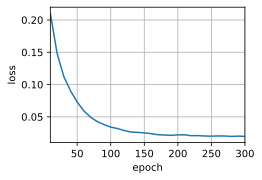

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## [**预测**]

为了采用一个接着一个标记的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测标记。与训练类似，序列开始标记（“&lt;bos&gt;”）在初始时间步被输入到解码器中。该预测过程如 :numref:`fig_seq2seq_predict` 所示。当输出序列的预测遇到序列结束标记（“&lt;eos&gt;”）时，预测就结束了。

![使用循环神经网络编码器-解码器逐标记地预测输出序列。](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

我们将在 :numref:`sec_beam-search` 中介绍不同的序列生成策略。


In [13]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将`net`设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的标记，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束标记被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。虽然 BLEU（Bilingual Evaluation Understudy）的提出最先是用于评估机器翻译的结果 :cite:`Papineni.Roukos.Ward.ea.2002` ，但现在它已经被广泛用于测量许多应用的输出序列的质量。原则上说，对于预测序列中的任意 $n$ 元语法（n-grams），BLEU 的评估都是这个 $n$ 元语法是否出现在标签序列中。

用 $p_n$ 表示 $n$ 元语法的精确度，它是两个数量的比值，第一个是预测序列与标签序列中匹配的 $n$ 元语法的数量，第二个是预测序列中 $n$ 元语法的数量的比率。详细解释，即给定的标签序列 $A$、$B$、$C$、$D$、$E$、$F$ 和预测序列 $A$、$B$、$B$、$C$、$D$，我们有 $p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$ 和 $p_4 = 0$。另外， $\mathrm{len}_{\text{label}}$ 表示标签序列中的标记数和 $\mathrm{len}_{\text{pred}}$ 表示预测序列中的标记数。那么，BLEU 的定义是：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中 $k$ 是用于匹配的最长的 $n$ 元语法。

根据 :eqref:`eq_bleu` 中 BLEU 的定义，当预测序列与标签序列完全相同时，BLEU 为 $1$。此外，由于 $n$ 元语法越长则匹配难度越大，所以 BLEU 为更长的 $n$ 元语法的精确度分配更大的权重。具体来说，当 $p_n$ 固定时，$p_n^{1/2^n}$ 会随着 $n$ 的增长而增加（原始论文使用 $p_n^{1/n}$）。而且，由于预测的序列越短获得的 $p_n$ 值越高，所以 :eqref:`eq_bleu` 中乘法项之前的系数用于惩罚较短的预测序列。例如，当 $k=2$ 时，给定标签序列 $A$、$B$、$C$、$D$、$E$、$F$ 和预测序列 $A$、$B$，尽管 $p_1 = p_2 = 1$，惩罚因子 $\exp(1-6/2) \approx 0.14$ 会降低 BLEU。

[**BLEU的代码实现**]如下。


In [14]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型[**将几个英语句子翻译成法语**]，并计算 BLEU 的最终结果。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis chez moi <unk> !, bleu 0.719


## 小结

* 根据“编码器-解码器”架构的设计，我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
* 在实现编码器和解码器时，我们可以使用多层循环神经网络。
* 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
* 在“编码器－解码器”训练中，教师强制方法将原始输出序列（而非预测结果）输入解码器。
* BLEU 是一种常用的评估方法，它通过测量预测序列和标签序列之间的 $n$ 元语法的匹配度来实现。

## 练习

1. 你能通过调整超参数来改善翻译效果吗？
1. 重新运行实验并在计算损失时不使用遮蔽。你观察到什么结果？为什么？
1. 如果编码器和解码器的层数或者隐藏单元数不同，那么如何初始化解码器的隐藏状态？
1. 在训练中，如果用前一时间步的预测输入到解码器来代替教师强制，对性能有何影响？
1. 用长短期记忆网络替换门控循环单元重新运行实验。
1. 有没有其他方法来设计解码器的输出层？


# 束搜索
:label:`sec_beam-search`

在 :numref:`sec_seq2seq` 中，我们逐个预测输出序列，直到预测序列中出现特定的序列结束标记“&lt;eos&gt;”。在
本节中，我们将首先介绍 *贪心搜索*（greedy search）策略，并探讨其存在的问题，然后对比其他替代策略：*穷举搜索*（exhaustive search）和*束搜索*（beam search）。

在正式介绍贪心搜索之前，让我们使用与 :numref:`sec_seq2seq` 中相同的数学符号定义搜索问题。在任意时间步 $t'$，解码器输出 $y_{t'}$ 的概率取决于时间步 $t'$ 之前的输出子序列 $y_1, \ldots, y_{t'-1}$ 和对输入序列的信息进行编码得到的上下文变量 $\mathbf{c}$。为了量化计算成本，用 $\mathcal{Y}$ 表示输出词汇表，其中包含“&lt;eos&gt;”，所以这个词汇集合的基数 $\left|\mathcal{Y}\right|$ 就是词汇表的大小。我们还将输出序列的最大标记数指定为 $T'$。因此，我们的目标是从所有 $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ 个可能的输出序列中寻找理想的输出。当然，对于所有输出序列，这些序列中包含的“&lt;eos&gt;”及其之后的部分将在实际输出中丢弃。

## 贪心搜索

首先，让我们看看一个简单的策略：*贪心搜索*。该策略已用于 :numref:`sec_seq2seq` 的序列预测。对于输出序列的任何时间步 $t'$，我们都将基于贪心搜索从 $\mathcal{Y}$ 中找到具有最高条件概率的标记，即：

$$y_{t'} = \operatorname*{argmax}_{y \in \mathcal{Y}} P(y \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$$

一旦输出序列包含了“&lt;eos&gt;”或者达到其最大长度 $T'$，则输出完成。

那么贪心搜索存在的问题是什么呢？现实中，*最优序列*（optimal sequence）应该是最大化 $\prod_{t'=1}^{T'} P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$ 值的输出序列，这是基于输入序列生成输出序列的条件概率。而不幸的是，无法保证通过贪心搜索得到最优序列。

![在每个时间步，贪心搜索选择具有最高条件概率的标记。](../img/s2s-prob1.svg)
:label:`fig_s2s-prob1`

让我们用一个例子来描述。假设输出中有四个标记“A”、“B”、“C”和“&lt;eos&gt;”。 在 :numref:`fig_s2s-prob1` 中，每个时间步下的四个数字分别表示在该时间步生成“A”、“B”、“C”和“&lt;eos&gt;”的条件概率。在每个时间步，贪心搜索选择具有最高条件概率的标记。因此，将在 :numref:`fig_s2s-prob1` 中预测输出序列“A”、“B”、“C”和“&lt;eos&gt;”。这个输出序列的条件概率是$0.5\times0.4\times0.4\times0.6 = 0.048$。

![每个时间步下的四个数字表示在该时间步生成“A”、“B”、“C”和“&lt;eos&gt;”的条件概率。在时间步2，选择具有第二高条件概率的令牌“C”。](../img/s2s-prob2.svg)
:label:`fig_s2s-prob2`

接下来，让我们看看 :numref:`fig_s2s-prob2` 中的另一个例子。与 :numref:`fig_s2s-prob1` 不同，在时间步 $2$ 中，我们选择 :numref:`fig_s2s-prob2` 中的标记“C”，它具有 *第二* 高的条件概率。由于时间步 $3$ 所基于的时间步 $1$ 和 $2$ 处的输出子序列已从 :numref:`fig_s2s-prob1` 中的“A”和“B”改变为 :numref:`fig_s2s-prob2` 中的“A”和“C”，因此时间步 $3$ 处的每个标记的条件概率也在 :numref:`fig_s2s-prob2` 中改变。假设我们在时间步 $3$ 选择标记“B”，于是当前的时间步 $4$ 基于前三个时间步的输出子序列“A”、“C”和“B”为条件，这与 :numref:`fig_s2s-prob1` 中的“A”、“B”和“C”不同。因此，在 :numref:`fig_s2s-prob2` 中的时间步 $4$ 生成每个标记的条件概率也不同于 :numref:`fig_s2s-prob1` 中的条件概率。结果， :numref:`fig_s2s-prob2` 中的输出序列“A”、“C”、“B”和“&lt;eos&gt;”的条件概率为 $0.5\times0.3 \times0.6\times0.6=0.054$，这大于 :numref:`fig_s2s-prob1` 中的贪心搜索的条件概率。通过例子说明，贪心搜索获得的输出序列“A”、“B”、“C”和“&lt;eos&gt;”不是最佳序列。

## 穷举搜索

如果目标是获得最优序列，我们可以考虑使用 *穷举搜索*（exhaustive search）：穷举地列举所有可能的输出序列及其条件概率，然后输出条件概率最高的一个。

虽然我们可以使用穷举搜索来获得最优序列，但其计算量 $\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$ 可能高的过分。例如，当 $|\mathcal{Y}|=10000$ 和 $T'=10$ 时，我们需要评估 $10000^{10} = 10^{40}$ 序列，这几乎是不可能的！另一方面，贪心搜索的计算量是 $\mathcal{O}(\left|\mathcal{Y}\right|T')$：通常它要显著地小于穷举搜索。例如，当 $|\mathcal{Y}|=10000$ 和 $T'=10$ 时，我们只需要评估 $10000\times10=10^5$ 个序列。

## 束搜索

那么该选取哪种序列搜索策略呢？如果只有正确性最重要，则显然是穷举搜索。如果计算成本最重要，则显然是贪心搜索。
而束搜索的实际应用则介于这两个极端之间。

*束搜索*（beam search）是贪心搜索的一个改进版本。
它有一个超参数，名为 *束宽*（beam size）$k$。
在时间步 $1$，我们选择具有最高条件概率的 $k$ 个标记。这 $k$ 个标记将分别是 $k$ 个候选输出序列的第一个标记。在随后的每个时间步，基于上一时间步的 $k$ 个候选输出序列，我们将继续从 $k\left|\mathcal{Y}\right|$ 个可能的选择中挑出具有最高条件概率的 $k$ 个候选输出序列。

![束搜索过程（束宽：2，输出序列的最大长度：3）。候选输出序列是$A$、$C$、$AB$、$CE$、$ABD$和$CED$。](../img/beam-search.svg)
:label:`fig_beam-search`

:numref:`fig_beam-search` 演示了束搜索的过程。假设输出的词汇表只包含五个元素：$\mathcal{Y} = \{A, B, C, D, E\}$，其中有一个是“&lt;eos&gt;”。设置束宽为 $2$，输出序列的最大长度为 $3$。在时间步 $1$，假设具有最高条件概率 $P(y_1 \mid \mathbf{c})$ 的标记是 $A$ 和 $C$。在时间步 $2$，我们计算所有 $y_2 \in \mathcal{Y}$ 为：

$$\begin{aligned}P(A, y_2 \mid \mathbf{c}) = P(A \mid \mathbf{c})P(y_2 \mid A, \mathbf{c}),\\ P(C, y_2 \mid \mathbf{c}) = P(C \mid \mathbf{c})P(y_2 \mid C, \mathbf{c}),\end{aligned}$$  

从这十个值中选择最大的两个，比如 $P(A, B \mid \mathbf{c})$ 和 $P(C, E \mid \mathbf{c})$。然后在时间步 $3$，我们计算所有 $y_3 \in \mathcal{Y}$ 为：

$$\begin{aligned}P(A, B, y_3 \mid \mathbf{c}) = P(A, B \mid \mathbf{c})P(y_3 \mid A, B, \mathbf{c}),\\P(C, E, y_3 \mid \mathbf{c}) = P(C, E \mid \mathbf{c})P(y_3 \mid C, E, \mathbf{c}),\end{aligned}$$ 

从这十个值中选择最大的两个，即$P(A, B, D \mid \mathbf{c})$和$P(C, E, D \mid  \mathbf{c})$。结果，我们得到六个候选输出序列：（1）$A$；（2）$C$；（3）$A,B$；（4）$C,E$；（5）$A,B,D$ ；（6）$C,E,D$。

最后，我们基于这六个序列（例如，丢弃包括“&lt;eos&gt;”和之后的部分）获得最终候选输出序列集合。然后我们选择以下得分最高的序列作为输出序列：

$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}),$$
:eqlabel:`eq_beam-search-score`

其中 $L$ 是最终候选序列的长度，$\alpha$ 通常设置为 $0.75$。因为一个较长的序列在  :eqref:`eq_beam-search-score` 的求和中会有更多的对数项，因此分母中的 $L^\alpha$ 用于惩罚长序列。

束搜索的计算量为 $\mathcal{O}(k\left|\mathcal{Y}\right|T')$，这个结果介于贪心搜索和穷举搜索之间。实际上，贪心搜索可以看作是一种束宽为 $1$ 的特殊类型的束搜索。通过灵活地选择束宽，束搜索可以在正确率和计算成本之间进行权衡。

## 小结

* 序列搜索策略包括贪心搜索、穷举搜索和束搜索。
* 束搜索通过灵活选择束宽，在正确率和计算成本之间找到平衡。

## 练习

1. 我们可以把穷举搜索看作一种特殊的束搜索吗？为什么？
1. 在 :numref:`sec_seq2seq` 的机器翻译问题中应用束搜索。束宽是如何影响预测的速度和结果的？
1. 在 :numref:`sec_rnn_scratch` 中，我们基于用户提供的前缀，通过使用语言模型来生成文本。那么例子中使用了哪种搜索策略？你能改进吗？

[Discussions](https://discuss.d2l.ai/t/2786)
